In [1]:
import os
import re
import sys
import ast
import time
import json
import nltk
import joblib
import warnings
import pandas as pd
from tqdm import tqdm
from gtts import gTTS
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from deep_translator import GoogleTranslator


warnings.filterwarnings("ignore")

# --- Configuration ---
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# Kaggle dataset files
METADATA_FILE = os.path.join(DATA_DIR, "movie.metadata.tsv")
SUMMARIES_FILE = os.path.join(DATA_DIR, "plot_summaries.txt")

# Processed files
RAW_TRANSLATIONS_FILE = os.path.join(DATA_DIR, "raw_translations.csv")
CLEANED_FILE = os.path.join(DATA_DIR, "cleaned_movies.csv")
TRAIN_FILE = os.path.join(DATA_DIR, "train_data.csv")
TEST_FILE = os.path.join(DATA_DIR, "test_data.csv")

# Model files
MODEL_FILE = os.path.join(DATA_DIR, "genre_model.pkl")
VECTORIZER_FILE = os.path.join(DATA_DIR, "tfidf_vectorizer.pkl")
MLB_FILE = os.path.join(DATA_DIR, "mlb.pkl")

# Audio output
AUDIO_DIR = "audio_output"
os.makedirs(AUDIO_DIR, exist_ok=True)

# Languages to support
LANGUAGES = {
    'ar': {'name': 'arabic', 'tts_code': 'ar'},
    'ur': {'name': 'urdu', 'tts_code': 'ur'}, 
    'ko': {'name': 'korean', 'tts_code': 'ko'}
}


TRANSLATION_SAMPLE_SIZE = 50


def initialize_nltk():
    """Download required NLTK resources with retries"""
    resources = ['punkt', 'wordnet', 'stopwords', 'omw-1.4']
    for resource in resources:
        for attempt in range(3):  # Retry up to 3 times
            try:
                nltk.download(resource, quiet=True)
                break
            except Exception as e:
                if attempt == 2:
                    print(f"Failed to download NLTK resource '{resource}': {e}")
                time.sleep(1)

    try:
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        return stop_words, lemmatizer
    except Exception as e:
        print(f"Error initializing NLTK components: {e}")
        return set(), None  # Fallback to empty stopwords and no lemmatizer

print("Initializing NLTK resources...")
stop_words, lemmatizer = initialize_nltk()

# --- PART 1: Data Loading ---
def load_kaggle_data():
    """Load and merge data from Kaggle files with robust error handling"""
    if not os.path.exists(METADATA_FILE) or not os.path.exists(SUMMARIES_FILE):
        print("Error: Required data files not found!")
        print(f"Please download these files from Kaggle and place in {DATA_DIR} folder:")
        print("- movie.metadata.tsv")
        print("- plot_summaries.txt")
        print("Dataset URL: https://www.kaggle.com/datasets/msafi04/movies-genre-dataset-cmu-movie-summary")
        return None
    
    try:
        
        print("Loading metadata...")
        metadata_cols = [
            'movie_id', 'freebase_id', 'name', 'release_date', 'revenue',
            'runtime', 'languages', 'countries', 'genres'
        ]
        metadata = pd.read_csv(METADATA_FILE, sep='\t', header=None, names=metadata_cols)
        
       
        print("Loading plot summaries...")
        summaries = pd.read_csv(SUMMARIES_FILE, sep='\t', header=None, names=['movie_id', 'summary'])
        
        
        print("Processing genres...")
        metadata['genres'] = metadata['genres'].apply(
            lambda x: list(ast.literal_eval(x).values()) if pd.notna(x) else []
        )
        
       
        print("Merging data...")
        merged = pd.merge(
            summaries,
            metadata[['movie_id', 'genres']],
            on='movie_id',
            how='inner'
        )
        
       
        merged = merged[merged['genres'].apply(len) > 0]
        
        return merged
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def create_sample_data():
    """Create sample data if loading fails"""
    return pd.DataFrame({
        'movie_id': [1, 2, 3],
        'summary': [
            "A group of astronauts travel to Mars and encounter alien life",
            "A romantic comedy about two people who meet in unusual circumstances",
            "A detective solves a series of mysterious crimes in a small town"
        ],
        'genres': [
            ["Sci-Fi", "Adventure"],
            ["Romance", "Comedy"],
            ["Mystery", "Crime"]
        ]
    })

# --- PART 2: Translation Function ---
def translate_text(text, target_lang, max_length=4000, retries=3):
    """Translate text with retries and length handling"""
    if not text or len(text) < 10:
        return ""
    
    text = text[:max_length]  # Ensure length limit
    
    for attempt in range(retries):
        try:
            translated = GoogleTranslator(
                source='en',
                target=target_lang
            ).translate(text)
            
            if translated and translated != text:
                return translated
            time.sleep(2)
        except Exception as e:
            print(f"Translation attempt {attempt+1} failed: {e}")
            time.sleep(2)
    
    return ""

def text_to_speech(text, lang_code, save_path, max_length=500, retries=3):
    """Convert text to speech with retries"""
    if not text or len(text) < 10:
        return False
    
    text = text[:max_length]  
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    for attempt in range(retries):
        try:
            tts = gTTS(
                text=text,
                lang=LANGUAGES[lang_code]['tts_code'],
                slow=False
            )
            tts.save(save_path)
            
            if os.path.exists(save_path) and os.path.getsize(save_path) > 1024:
                return True
            time.sleep(2)
        except Exception as e:
            print(f"TTS attempt {attempt+1} failed: {e}")
            time.sleep(2)
    
    return False

def process_translations(df):
    """Process translations and audio conversions before preprocessing"""
    print("\nProcessing translations for movie summaries...")
    
   
    df_trans = df.copy()
    
    
    for lang_code in LANGUAGES:
        df_trans[f'translated_{lang_code}'] = ""
    
   
    sample_df = df.head(TRANSLATION_SAMPLE_SIZE)
    
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Translating"):
        movie_id = row['movie_id']
        summary = row['summary']
        
        if not summary or len(summary) < 20:
            continue
            
        for lang_code in LANGUAGES:
            lang_name = LANGUAGES[lang_code]['name']
            base_path = os.path.join(AUDIO_DIR, f"{movie_id}_{lang_name}")
            
            
            if os.path.exists(f"{base_path}.txt"):
                continue
                
           
            translated = translate_text(summary, lang_code)
            if not translated:
                continue
                
            
            df_trans.at[idx, f'translated_{lang_code}'] = translated
            
            with open(f"{base_path}.txt", 'w', encoding='utf-8') as f:
                f.write(translated)
            
         
            text_to_speech(translated, lang_code, f"{base_path}.mp3")
    
   
    df_trans.to_csv(RAW_TRANSLATIONS_FILE, index=False)
    return df_trans

# --- PART 3: Text Preprocessing ---
def clean_text(text):
    """Clean and preprocess text with robust error handling"""
    if not isinstance(text, str):
        return ""
    
    try:
        
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        
        # Tokenization with fallback
        try:
            tokens = nltk.word_tokenize(text)
        except:
            tokens = text.split()
        
        # Lemmatization with fallback
        if lemmatizer is not None:
            tokens = [lemmatizer.lemmatize(w) for w in tokens 
                     if w not in stop_words and len(w) > 1]
        else:
            tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
        
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return text.lower()  # Fallback to simple lowercase

def preprocess_data(df):
    """Preprocess the entire dataset"""
    print("Preprocessing text...")
    df['cleaned_summary'] = [clean_text(text) for text in tqdm(df['summary'], desc="Cleaning")]
    
    # Filter out rare genres
    print("Filtering genres...")
    genre_counts = df['genres'].explode().value_counts()
    common_genres = genre_counts[genre_counts >= 50].index
    df['genres'] = df['genres'].apply(lambda x: [g for g in x if g in common_genres])
    df = df[df['genres'].apply(len) > 0]
    
    return df

# --- PART 4: Genre Prediction Model ---
def train_genre_model(df_train, df_test):
    """Train and evaluate the genre classification model"""
    print("\n=== Training Genre Prediction Model ===")
    
    # Multi-label binarizer
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(df_train['genres'])
    y_test = mlb.transform(df_test['genres'])
    
    # Feature extraction (TF-IDF)
    print("Extracting features with TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english'
    )
    X_train = vectorizer.fit_transform(df_train['cleaned_summary'])
    X_test = vectorizer.transform(df_test['cleaned_summary'])
    
    # Model training (Logistic Regression with OneVsRest)
    print("Training model...")
    model = OneVsRestClassifier(
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        ),
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # PART 5: Evaluation
    print("\nModel Evaluation:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))
    
   
    joblib.dump(model, MODEL_FILE)
    joblib.dump(vectorizer, VECTORIZER_FILE)
    joblib.dump(mlb, MLB_FILE)
    
    return model, vectorizer, mlb

def predict_genres(text, model, vectorizer, mlb):
    """Predict genres from a text summary"""
    if not text or len(text) < 10:
        return []
    
   
    cleaned_text = clean_text(text)
    X = vectorizer.transform([cleaned_text])
    
   
    y_pred = model.predict(X)
    genres = mlb.inverse_transform(y_pred)
    
    return list(genres[0]) if genres[0] else []

# --- Audio Playback ---
def play_audio(filepath):
    """System-agnostic audio playback"""
    try:
        if sys.platform == 'win32':
            os.startfile(filepath)
        elif sys.platform == 'darwin':
            os.system(f'open "{filepath}"')
        else:
            os.system(f'xdg-open "{filepath}"')
        return True
    except Exception as e:
        print(f"Error playing audio: {e}")
        return False

# --- Main Workflow ---
def main():
    print("🎀 FILMCEPTION , BY SABREENA AND BAKHTAWAR 🎀")
    
    # Step 1: Loading raw data
    if os.path.exists(RAW_TRANSLATIONS_FILE):
        print("Loading pre-translated data...")
        df = pd.read_csv(RAW_TRANSLATIONS_FILE)
        df['genres'] = df['genres'].apply(ast.literal_eval)
    else:
        print("Loading raw data...")
        df = load_kaggle_data()
        
        if df is None:
            print("Creating sample data...")
            df = create_sample_data()
        
        # Step 2: Processing translations and audio
        df = process_translations(df)
    
    # Step 3: Preprocess data
    if os.path.exists(CLEANED_FILE):
        print("Loading preprocessed data...")
        df_clean = pd.read_csv(CLEANED_FILE)
        df_clean['genres'] = df_clean['genres'].apply(ast.literal_eval)
    else:
        print("\nPreprocessing data...")
        df_clean = preprocess_data(df)
        df_clean.to_csv(CLEANED_FILE, index=False)
    
    print(f"\nLoaded {len(df_clean)} movies with genres")
    
    # Step 4: Train-test split
    if os.path.exists(TRAIN_FILE) and os.path.exists(TEST_FILE):
        print("Loading existing train/test split...")
        df_train = pd.read_csv(TRAIN_FILE)
        df_test = pd.read_csv(TEST_FILE)
        df_train['genres'] = df_train['genres'].apply(ast.literal_eval)
        df_test['genres'] = df_test['genres'].apply(ast.literal_eval)
    else:
        print("Creating train/test split...")
        df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=42)
        df_train.to_csv(TRAIN_FILE, index=False)
        df_test.to_csv(TEST_FILE, index=False)
    
    # Step 5: Train or load model
    if os.path.exists(MODEL_FILE):
        print("Loading existing model...")
        model = joblib.load(MODEL_FILE)
        vectorizer = joblib.load(VECTORIZER_FILE)
        mlb = joblib.load(MLB_FILE)
    else:
        model, vectorizer, mlb = train_genre_model(df_train, df_test)
    
    # menu
    while True:
        print("\n==== Main Menu ====")
        print("1. Translate a movie (any ID)")
        print("2. Play existing translations")
        print("3. Predict genres from summary")
        print("4. Exit")
        
        choice = input("Enter choice (1-4): ").strip()
        
        if choice == '1':
           
            print("\nAvailable movies (sample):")
            print(df[['movie_id', 'summary']].head(10).to_string(index=False))
            
            movie_id = input("\n🎀Enter movie ID to translate: ").strip()
            try:
                movie_id = int(movie_id)
                if movie_id not in df['movie_id'].values:
                    print("Movie ID not found")
                    continue
            except ValueError:
                print("Please enter a valid number")
                continue
                
            print("\nAvailable languages:")
            for code, config in LANGUAGES.items():
                print(f"{code}: {config['name']}")
                
            lang_code = input("Enter language code: ").strip().lower()
            if lang_code not in LANGUAGES:
                print("Invalid language code")
                continue
                
            movie_row = df[df['movie_id'] == movie_id].iloc[0]
            summary = movie_row['summary']
            lang_name = LANGUAGES[lang_code]['name']
            base_path = os.path.join(AUDIO_DIR, f'{movie_id}_{lang_name}')
            
       
            translated = translate_text(summary, lang_code)
            if not translated:
                print("Translation failed")
                continue
                
          
            with open(f"{base_path}.txt", 'w', encoding='utf-8') as f:
                f.write(translated)
            print(f"Saved {lang_name} translation to {base_path}.txt")
            
            if text_to_speech(translated, lang_code, f"{base_path}.mp3"):
                print("Audio generated successfully")
                play_audio(f"{base_path}.mp3")
            else:
                print("Failed to generate audio")
                
        elif choice == '2':
           
            audio_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.mp3')]
            
            if not audio_files:
                print("No audio files available")
                continue
                
            print("\nAvailable audio files:")
            for i, f in enumerate(audio_files, 1):
                print(f"{i}. {f}")
                
            selection = input("\n🎀 Select file to play (or 'back'): ").strip()
            if selection.lower() == 'back':
                continue
                
            try:
                idx = int(selection) - 1
                if 0 <= idx < len(audio_files):
                    play_audio(os.path.join(AUDIO_DIR, audio_files[idx]))
                else:
                    print("Invalid selection")
            except ValueError:
                print("Please enter a valid number")
        
        elif choice == '3':
           
            print("\n=== Genre Prediction ===")
            print("🎀Enter a movie summary to predict its genres")
            print("🎀Example: 'A space adventure about astronauts discovering alien life'")
            
            user_summary = input("\nEnter summary: ").strip()
            if not user_summary:
                print("Please enter a summary")
                continue
                
           
            genres = predict_genres(user_summary, model, vectorizer, mlb)
            
            print("\nPredicted Genres:")
            if genres:
                for genre in genres:
                    print(f"- {genre}")
            else:
                print("No genres predicted")
                
            
            if user_summary in df['summary'].values:
                movie_row = df[df['summary'] == user_summary].iloc[0]
                print("\nActual Genres:")
                for genre in movie_row['genres']:
                    print(f"- {genre}")
        
        elif choice == '4':
            print("🎀Exit")
            break
        else:
            print("Invalid choice")

if __name__ == "__main__":
    main()

Initializing NLTK resources...
🎀 FILMCEPTION , BY SABREENA AND BAKHTAWAR 🎀
Loading raw data...
Loading metadata...
Loading plot summaries...
Processing genres...
Merging data...

Processing translations for movie summaries...


Translating: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [25:29<00:00, 30.58s/it]



Preprocessing data...
Preprocessing text...


Cleaning: 100%|█████████████████████████████████████████████████████████████████| 41793/41793 [03:00<00:00, 231.88it/s]


Filtering genres...

Loaded 41761 movies with genres
Creating train/test split...

=== Training Genre Prediction Model ===
Extracting features with TF-IDF...
Training model...

Model Evaluation:
                           precision    recall  f1-score   support

                Absurdism       0.00      0.00      0.00        13
                   Action       0.42      0.76      0.54      1201
            Action Comedy       0.06      0.20      0.10        35
         Action Thrillers       0.12      0.46      0.19        91
         Action/Adventure       0.31      0.76      0.44       700
                    Adult       0.11      0.30      0.16        23
                Adventure       0.30      0.70      0.42       663
         Adventure Comedy       0.07      0.24      0.11        21
   Airplanes and airports       0.11      0.62      0.18         8
               Alien Film       0.19      0.64      0.29        22
                Americana       0.02      0.07      0.03        14


Enter choice (1-4):  1



Available movies (sample):
 movie_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


🎀Enter movie ID to translate:  20532852



Available languages:
ar: arabic
ur: urdu
ko: korean


Enter language code:  ar


Saved arabic translation to audio_output\20532852_arabic.txt
Audio generated successfully

==== Main Menu ====
1. Translate a movie (any ID)
2. Play existing translations
3. Predict genres from summary
4. Exit


Enter choice (1-4):  2



Available audio files:
1. 10799612_arabic.mp3
2. 10799612_korean.mp3
3. 10799612_urdu.mp3
4. 12978934_arabic.mp3
5. 12978934_korean.mp3
6. 12978934_urdu.mp3
7. 1335380_arabic.mp3
8. 1335380_korean.mp3
9. 1335380_urdu.mp3
10. 13455076_arabic.mp3
11. 13455076_korean.mp3
12. 13455076_urdu.mp3
13. 14330027_arabic.mp3
14. 14330027_korean.mp3
15. 14330027_urdu.mp3
16. 1480747_arabic.mp3
17. 1480747_korean.mp3
18. 1480747_urdu.mp3
19. 15072401_arabic.mp3
20. 15072401_korean.mp3
21. 15072401_urdu.mp3
22. 15224586_arabic.mp3
23. 15224586_korean.mp3
24. 15224586_urdu.mp3
25. 15401493_arabic.mp3
26. 15401493_korean.mp3
27. 15401493_urdu.mp3
28. 15585766_arabic.mp3
29. 15585766_korean.mp3
30. 15585766_urdu.mp3
31. 17124781_arabic.mp3
32. 17124781_korean.mp3
33. 17124781_urdu.mp3
34. 1760737_arabic.mp3
35. 1760737_korean.mp3
36. 1760737_urdu.mp3
37. 18188932_arabic.mp3
38. 18188932_korean.mp3
39. 18188932_urdu.mp3
40. 1838882_arabic.mp3
41. 1838882_korean.mp3
42. 1838882_urdu.mp3
43. 18549958_arab


🎀 Select file to play (or 'back'):  150



==== Main Menu ====
1. Translate a movie (any ID)
2. Play existing translations
3. Predict genres from summary
4. Exit


Enter choice (1-4):  3



=== Genre Prediction ===
🎀Enter a movie summary to predict its genres
🎀Example: 'A space adventure about astronauts discovering alien life'



Enter summary:  The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by the bullet that hits the president. The shooter is gunned down by Alex and other secret service agents. The president dies at the hospital. Kate Crawford , an investigative journalist, starts asking questions about the assassination. Anyone she questions is killed. She goes to Alex Thomas's house to tell him what is happening. As they head to his boat, Thomas sees some men hiding in the bushes. He throws Kate into the water and dives in. Thomas jumps out of the water to kill two of the hitmen while a third hitman drives off to inform his boss what happened. They are able to link the hitmen to a man called Jack Baldwin . Agent Thomas and other Secret Service members attack the loc


Predicted Genres:
- Action
- Action/Adventure
- Crime Fiction
- Crime Thriller
- Indie
- Mystery
- Political drama
- Political thriller
- Psychological thriller
- Spy
- Suspense
- Thriller

Actual Genres:
- Thriller
- Action/Adventure
- Action
- Drama

==== Main Menu ====
1. Translate a movie (any ID)
2. Play existing translations
3. Predict genres from summary
4. Exit


Enter choice (1-4):  4


🎀Exit


In [14]:
# EVALUATION METRICS 

import joblib
import pandas as pd
from sklearn.metrics import (
    classification_report, 
    hamming_loss,
    precision_score,
    recall_score,  
    f1_score
)


MODEL_FILE = "data/genre_model.pkl"
VECTORIZER_FILE = "data/tfidf_vectorizer.pkl"
MLB_FILE = "data/mlb.pkl"
TEST_FILE = "data/test_data.csv"

def load_data_and_model():
    """Load the test data and trained model components"""
    # Load test data
    df_test = pd.read_csv(TEST_FILE)
    df_test['genres'] = df_test['genres'].apply(ast.literal_eval)
    
   
    model = joblib.load(MODEL_FILE)
    vectorizer = joblib.load(VECTORIZER_FILE)
    mlb = joblib.load(MLB_FILE)
    
    return df_test, model, vectorizer, mlb

def evaluate_model(df_test, model, vectorizer, mlb):
    """Evaluate the model and print key metrics"""
    
    X_test = vectorizer.transform(df_test['cleaned_summary'])
    y_test = mlb.transform(df_test['genres'])
    
  
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    
    print("\n=== Key Evaluation Metrics ===")
    print(f"{'Hamming Loss:':<20} {h_loss:.4f}")
    print(f"{'Weighted Precision:':<20} {precision:.4f}")
    print(f"{'Weighted Recall:':<20} {recall:.4f}")  # Added recall output
    print(f"{'Weighted F1-Score:':<20} {f1:.4f}")
    
   
    print("\n=== Interpretation ===")
    if h_loss < 0.5:
        print("🎀 Nice Work Bakhtawar and Sabreena : Hamming Loss < 0.5 indicates good multi-label performance")
    else:
        print("Warning: Hamming Loss ≥ 0.5 suggests room for improvement")
    
    print(f"\nPrecision of {precision:.2f} means the model is {precision*100:.0f}% reliable when predicting a genre")
    print(f"Recall of {recall:.2f} means the model finds {recall*100:.0f}% of relevant genres")  # Added recall interpretation
    print(f"F1-Score of {f1:.2f} balances precision and recall performance")
    
    return {
        'hamming_loss': h_loss,
        'precision': precision,
        'recall': recall, 
        'f1_score': f1
    }

def main():
    print("🎀 FilmCeption Model Evaluation - Key Metrics 🎀")

    df_test, model, vectorizer, mlb = load_data_and_model()
    
   
    metrics = evaluate_model(df_test, model, vectorizer, mlb)

if __name__ == "__main__":
    main()

🎀 FilmCeption Model Evaluation - Key Metrics 🎀

=== Key Evaluation Metrics ===
Hamming Loss:        0.0436
Weighted Precision:  0.3343
Weighted Recall:     0.6271
Weighted F1-Score:   0.4212

=== Interpretation ===
🎀 Nice Work Bakhtawar and Sabreena : Hamming Loss < 0.5 indicates good multi-label performance

Precision of 0.33 means the model is 33% reliable when predicting a genre
Recall of 0.63 means the model finds 63% of relevant genres
F1-Score of 0.42 balances precision and recall performance


🎀 FilmCeption Model Evaluation 🎀

=== Evaluation Metrics ===
Hamming Loss: 0.0436
Weighted Precision: 0.3343
Weighted Recall: 0.6271
Weighted F1-Score: 0.4212

=== Classification Report ===
                           precision    recall  f1-score   support

                Absurdism       0.00      0.00      0.00        13
                   Action       0.42      0.76      0.54      1201
            Action Comedy       0.06      0.20      0.10        35
         Action Thrillers       0.12      0.46      0.19        91
         Action/Adventure       0.31      0.76      0.44       700
                    Adult       0.11      0.30      0.16        23
                Adventure       0.30      0.70      0.42       663
         Adventure Comedy       0.07      0.24      0.11        21
   Airplanes and airports       0.11      0.62      0.18         8
               Alien Film       0.19      0.64      0.29        22
                Americana       0.02      0.07      0.03        14
     

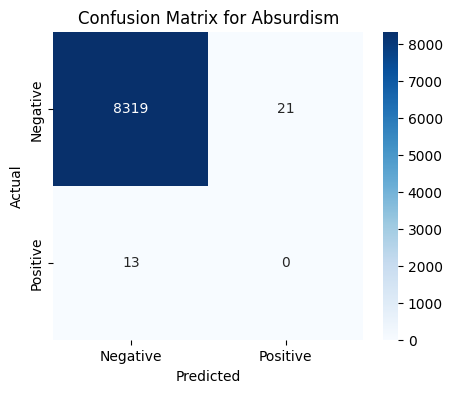

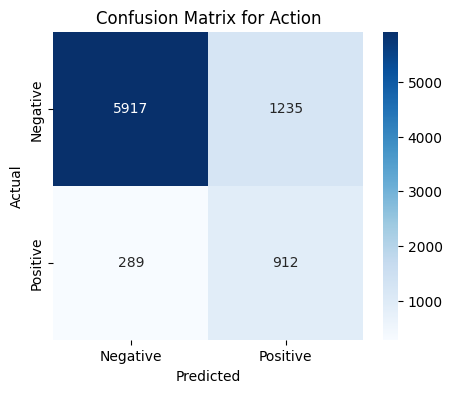

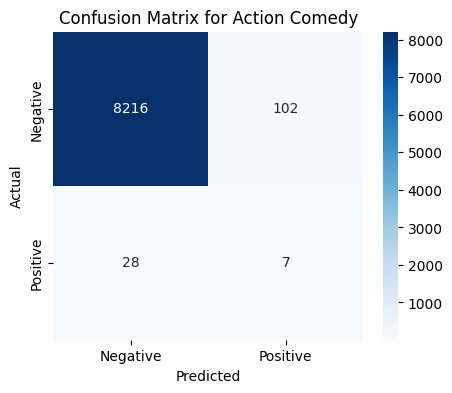

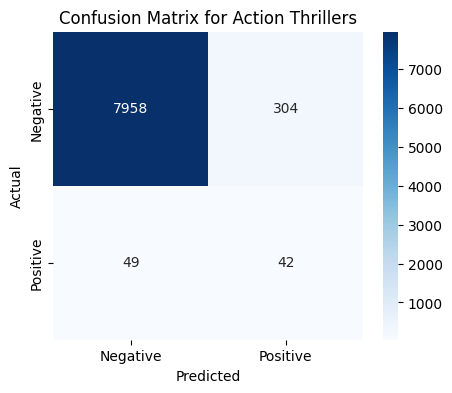

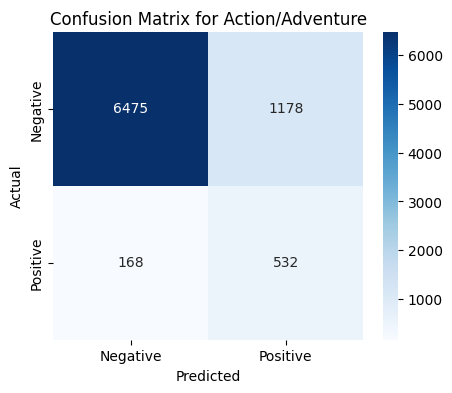

In [10]:
#Confusion Metrices
import joblib
import pandas as pd
from sklearn.metrics import (
    classification_report, 
    hamming_loss,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_FILE = "data/genre_model.pkl"
VECTORIZER_FILE = "data/tfidf_vectorizer.pkl"
MLB_FILE = "data/mlb.pkl"
TEST_FILE = "data/test_data.csv"

def load_data_and_model():
    """Load the test data and trained model components"""

    df_test = pd.read_csv(TEST_FILE)
    df_test['genres'] = df_test['genres'].apply(ast.literal_eval)
    
    model = joblib.load(MODEL_FILE)
    vectorizer = joblib.load(VECTORIZER_FILE)
    mlb = joblib.load(MLB_FILE)
    
    return df_test, model, vectorizer, mlb

def evaluate_model(df_test, model, vectorizer, mlb):
    """Evaluate the model and print metrics"""
 
    X_test = vectorizer.transform(df_test['cleaned_summary'])
    y_test = mlb.transform(df_test['genres'])
   
    y_pred = model.predict(X_test)
    
    h_loss = hamming_loss(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    
    print("\n=== Evaluation Metrics ===")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
  
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))
    
   
    if h_loss < 0.5:  \
        print("\n🎀 Success! Hamming Loss is less than 0.5, which means your model performs well.")
    else:
        print("\n Warning: Hamming Loss is 0.5 or higher, which means the model needs improvement.")
    
    return y_test, y_pred, mlb.classes_

def plot_confusion_matrices(y_test, y_pred, classes, max_classes=5):
    """Plot confusion matrices for the first few classes"""
    
    cm = multilabel_confusion_matrix(y_test, y_pred)
    
   
    for i, (matrix, class_name) in enumerate(zip(cm, classes)):
        if i >= max_classes:
            break
            
        plt.figure(figsize=(5, 4))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for {class_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

def main():
    print("🎀 FilmCeption Model Evaluation 🎀")
    
  
    df_test, model, vectorizer, mlb = load_data_and_model()
    
  
    y_test, y_pred, classes = evaluate_model(df_test, model, vectorizer, mlb)
    
   
    plot_confusion_matrices(y_test, y_pred, classes)

if __name__ == "__main__":
    main()

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Bia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('punkt', download_dir='C:/nltk_data')

[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [12]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog, scrolledtext
import os
import pandas as pd
import ast
from gtts import gTTS
from PIL import Image, ImageTk
import joblib
from sklearn.metrics import (
    classification_report, 
    hamming_loss,
    precision_score,
    recall_score,
    f1_score
)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import platform
import subprocess
import webbrowser
from deep_translator import GoogleTranslator


nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

class FilmCeptionApp:
    def __init__(self, root):
        self.root = root
        self.setup_window()
        self.load_data()
        self.create_widgets()
        self.center_window()
        
    def setup_window(self):
        self.root.title("🎀 FilmCeption - By Sabreena and Bakhtawar 🎀")
        self.root.geometry("1000x750")
        self.root.minsize(900, 700)
        self.root.configure(bg="#FFEEF9")
        
        style = ttk.Style()
        style.theme_use('clam')
        style.configure('TFrame', background="#FFEEF9")
        style.configure('TLabel', background="#FFEEF9", font=('Helvetica', 10))
        style.configure('TButton', font=('Helvetica', 10), padding=5)
        style.configure('TNotebook', background="#FFEEF9")
        style.configure('TNotebook.Tab', font=('Helvetica', 10, 'bold'), padding=[10, 5])
        style.map('TNotebook.Tab', 
                 background=[('selected', '#FF69B4')], 
                 foreground=[('selected', 'white')])
        
    def load_data(self):
        try:
            self.cleaned_data = pd.read_csv("data/cleaned_movies.csv")
            self.cleaned_data['genres'] = self.cleaned_data['genres'].apply(ast.literal_eval)
            self.model = joblib.load("data/genre_model.pkl")
            self.vectorizer = joblib.load("data/tfidf_vectorizer.pkl")
            self.mlb = joblib.load("data/mlb.pkl")
            os.makedirs("audio_output", exist_ok=True)
            os.makedirs("translations", exist_ok=True)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load data/models: {str(e)}")
            self.root.destroy()
    
    def create_widgets(self):
      
        header_frame = tk.Frame(self.root, bg="#FF69B4", height=100)
        header_frame.pack(fill="x", padx=10, pady=10)
        
        title_frame = tk.Frame(header_frame, bg="#FF69B4")
        title_frame.pack(expand=True)
        
        tk.Label(title_frame, text="🎀", font=("Helvetica", 24), bg="#FF69B4", fg="white").pack(side="left")
        tk.Label(title_frame, text="Filmception , by Sabreena and Bakhtawar", font=("Helvetica", 24, "bold"), 
                bg="#FF69B4", fg="white").pack(side="left", padx=10)
        tk.Label(title_frame, text="🎀", font=("Helvetica", 24), bg="#FF69B4", fg="white").pack(side="left")
        
        
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill="both", expand=True, padx=10, pady=(0, 10))
        
    
        self.create_translate_tab()
        self.create_audio_tab()
        self.create_predict_tab()
        self.create_metrics_tab()
        
   
        footer_frame = tk.Frame(self.root, bg="#FF69B4", height=50)
        footer_frame.pack(fill="x", padx=10, pady=(0, 10))
        
        tk.Button(footer_frame, text="Help", command=self.show_help, 
                 bg="#FFB6C1", fg="black", font=("Helvetica", 10)).pack(side="left", padx=10)
        tk.Button(footer_frame, text="Exit", command=self.root.quit,
                 bg="#FF1493", fg="white", font=("Helvetica", 10, "bold")).pack(side="right", padx=10)
    
    def create_translate_tab(self):
        tab = ttk.Frame(self.notebook)
        self.notebook.add(tab, text="Translate Movie")
        
        content_frame = ttk.Frame(tab)
        content_frame.pack(fill="both", expand=True, padx=10, pady=10)
        
       
        left_frame = ttk.Frame(content_frame)
        left_frame.pack(side="left", fill="y", padx=5, pady=5)
        
        tk.Label(left_frame, text="Available Movies", font=("Helvetica", 11, "bold")).pack(pady=5)
        
        self.movie_tree = ttk.Treeview(left_frame, columns=('id', 'summary'), show='headings', height=15)
        self.movie_tree.heading('id', text='ID')
        self.movie_tree.heading('summary', text='Summary')
        self.movie_tree.column('id', width=50, anchor='center')
        self.movie_tree.column('summary', width=300)
        self.movie_tree.pack(fill="y", expand=True)
        
        scrollbar = ttk.Scrollbar(left_frame, orient="vertical", command=self.movie_tree.yview)
        self.movie_tree.configure(yscrollcommand=scrollbar.set)
        scrollbar.pack(side="right", fill="y")
        
        
        right_frame = ttk.Frame(content_frame)
        right_frame.pack(side="right", fill="both", expand=True, padx=5, pady=5)
        
       
        lang_frame = ttk.Frame(right_frame)
        lang_frame.pack(fill="x", pady=5)
        
        tk.Label(lang_frame, text="Target Language:").pack(side="left")
        
        self.lang_var = tk.StringVar()
        lang_menu = ttk.Combobox(lang_frame, textvariable=self.lang_var, 
                               values=["Arabic (ar)", "Urdu (ur)", "Korean (ko)"], 
                               state="readonly")
        lang_menu.current(0)
        lang_menu.pack(side="left", padx=5)
        
        btn_frame = ttk.Frame(right_frame)
        btn_frame.pack(fill="x", pady=10)
        
        tk.Button(btn_frame, text="Translate Selected", command=self.translate_movie,
                 bg="#FF69B4", fg="white", font=("Helvetica", 10, "bold")).pack(side="left")
        
       
        tk.Label(right_frame, text="Translation Results", font=("Helvetica", 11, "bold")).pack(anchor="w")
        
        self.translation_text = scrolledtext.ScrolledText(right_frame, width=60, height=15,
                                                        wrap=tk.WORD, font=("Helvetica", 10))
        self.translation_text.pack(fill="both", expand=True)
        
       
        self.populate_movie_list()
    
    def create_audio_tab(self):
        tab = ttk.Frame(self.notebook)
        self.notebook.add(tab, text="Audio Tools")
        
        top_frame = ttk.Frame(tab)
        top_frame.pack(fill="x", padx=10, pady=10)
        
        bottom_frame = ttk.Frame(tab)
        bottom_frame.pack(fill="both", expand=True, padx=10, pady=10)
        
        
        file_frame = ttk.Frame(top_frame)
        file_frame.pack(fill="x", pady=5)
        
        tk.Label(file_frame, text="Audio File:").pack(side="left")
        
        self.audio_file_var = tk.StringVar()
        tk.Entry(file_frame, textvariable=self.audio_file_var, width=50).pack(side="left", padx=5)
        
        tk.Button(file_frame, text="Browse", command=self.browse_audio_file).pack(side="left")
        
      
        control_frame = ttk.Frame(top_frame)
        control_frame.pack(fill="x", pady=10)
        
        tk.Button(control_frame, text="Play", command=self.play_audio_file,
                 bg="#4CAF50", fg="white").pack(side="left", padx=5)
        tk.Button(control_frame, text="Stop", command=self.stop_audio,
                 bg="#F44336", fg="white").pack(side="left", padx=5)
        
     
        gen_frame = ttk.Frame(bottom_frame)
        gen_frame.pack(fill="both", expand=True)
        
        tk.Label(gen_frame, text="Generate Audio from Text", font=("Helvetica", 11, "bold")).pack(anchor="w")
        
        self.summary_entry = scrolledtext.ScrolledText(gen_frame, width=60, height=8,
                                                     wrap=tk.WORD, font=("Helvetica", 10))
        self.summary_entry.pack(fill="x", pady=5)
        
        tk.Button(gen_frame, text="Generate Audio", command=self.generate_audio,
                 bg="#2196F3", fg="white").pack(pady=5)
    
    def create_predict_tab(self):
        tab = ttk.Frame(self.notebook)
        self.notebook.add(tab, text="Genre Prediction")
        
        input_frame = ttk.Frame(tab)
        input_frame.pack(fill="x", padx=10, pady=10)
        
        result_frame = ttk.Frame(tab)
        result_frame.pack(fill="both", expand=True, padx=10, pady=10)
        
      
        tk.Label(input_frame, text="Enter Movie Summary:", font=("Helvetica", 11, "bold")).pack(anchor="w")
        
        self.predict_text = scrolledtext.ScrolledText(input_frame, width=80, height=10,
                                                    wrap=tk.WORD, font=("Helvetica", 10))
        self.predict_text.pack(fill="x", pady=5)
        
     
        btn_frame = ttk.Frame(input_frame)
        btn_frame.pack(fill="x", pady=5)
        
        tk.Button(btn_frame, text="Insert Example", command=self.insert_example).pack(side="left")
        tk.Button(btn_frame, text="Predict Genres", command=self.predict_genres,
                 bg="#9C27B0", fg="white", font=("Helvetica", 10, "bold")).pack(side="right")
        
        
        tk.Label(result_frame, text="Predicted Genres:", font=("Helvetica", 11, "bold")).pack(anchor="w")
        
        self.genre_result = tk.Listbox(result_frame, width=80, height=6,
                                     font=("Helvetica", 10), selectbackground="#FF69B4")
        self.genre_result.pack(fill="both", expand=True, pady=5)
    
    def create_metrics_tab(self):
        tab = ttk.Frame(self.notebook)
        self.notebook.add(tab, text="Model Metrics")
        
        content_frame = ttk.Frame(tab)
        content_frame.pack(fill="both", expand=True, padx=10, pady=10)
        
        tk.Label(content_frame, text="Model Performance Metrics", font=("Helvetica", 12, "bold")).pack(pady=5)
        
        self.metrics_text = scrolledtext.ScrolledText(content_frame, width=80, height=20,
                                                    wrap=tk.WORD, font=("Helvetica", 10))
        self.metrics_text.pack(fill="both", expand=True)
        
        tk.Button(content_frame, text="Load Evaluation Metrics", command=self.show_metrics,
                 bg="#607D8B", fg="white", font=("Helvetica", 10, "bold")).pack(pady=10)
    
    def populate_movie_list(self):
        try:
            movies = self.cleaned_data[['movie_id', 'summary']].head(50).to_dict('records')
            for movie in movies:
                self.movie_tree.insert('', tk.END, values=(movie['movie_id'], movie['summary']))
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load movies: {str(e)}")

    def translate_movie(self):
        selected = self.movie_tree.focus()
        if not selected:
            messagebox.showwarning("Warning", "Please select a movie first")
            return
        
        lang_code = self.lang_var.get().split("(")[1].split(")")[0]
        if not lang_code:
            messagebox.showwarning("Warning", "Please select a language")
            return
        
        try:
            item = self.movie_tree.item(selected)
            movie_id = item['values'][0]
            movie_row = self.cleaned_data[self.cleaned_data['movie_id'] == movie_id].iloc[0]
            summary = movie_row['summary']
            
            translated = GoogleTranslator(source='en', target=lang_code).translate(summary[:500])
            
            lang_name = self.lang_var.get().split("(")[0].strip().lower()
            txt_file = f"translations/{movie_id}_{lang_name}.txt"
            
            with open(txt_file, 'w', encoding='utf-8') as f:
                f.write(translated)
            
            self.translation_text.delete(1.0, tk.END)
            self.translation_text.insert(tk.END, translated)
            
            messagebox.showinfo("Success", f"Translation saved to {txt_file}")
            
        except Exception as e:
            messagebox.showerror("Error", f"Translation failed: {str(e)}")

    def browse_audio_file(self):
        filepath = filedialog.askopenfilename(
            initialdir="audio_output",
            title="Select Audio File",
            filetypes=(("MP3 files", "*.mp3"), ("All files", "*.*")))
        if filepath:
            self.audio_file_var.set(filepath)

    def play_audio_file(self):
        filepath = self.audio_file_var.get()
        if not filepath:
            messagebox.showwarning("Warning", "Please select an audio file first")
            return
        
        try:
            if platform.system() == 'Windows':
                os.startfile(filepath)
            elif platform.system() == 'Darwin':
                subprocess.call(('open', filepath))
            else:
                subprocess.call(('xdg-open', filepath))
        except Exception as e:
            messagebox.showerror("Error", f"Failed to play audio: {str(e)}")

    def stop_audio(self):
        if platform.system() == 'Windows':
            os.system('taskkill /f /im wmplayer.exe')

    def generate_audio(self):
        text = self.summary_entry.get(1.0, tk.END).strip()
        if not text:
            messagebox.showwarning("Warning", "Please enter text first")
            return
        
        try:
            lang_code = self.lang_var.get().split("(")[1].split(")")[0]
            tts = gTTS(text=text[:500], lang=lang_code, slow=False)
            output_file = "audio_output/generated_audio.mp3"
            tts.save(output_file)
            self.audio_file_var.set(output_file)
            messagebox.showinfo("Success", f"Audio saved to {output_file}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to generate audio: {str(e)}")

    def insert_example(self):
        example = "A group of astronauts travel to Mars and encounter alien life forms."
        self.predict_text.delete(1.0, tk.END)
        self.predict_text.insert(tk.END, example)

    def predict_genres(self):
        text = self.predict_text.get(1.0, tk.END).strip()
        if not text:
            messagebox.showwarning("Warning", "Please enter a summary first")
            return
        
        try:
            
            cleaned_input = self.clean_text(text)
            
            best_match = None
            highest_similarity = 0
            
            for _, row in self.cleaned_data.iterrows():
                
                db_summary = self.clean_text(row['summary'])
                
                input_words = set(cleaned_input.split())
                db_words = set(db_summary.split())
                common_words = input_words & db_words
                similarity = len(common_words) / max(len(input_words), 1)
                
                
                if similarity > highest_similarity:
                    highest_similarity = similarity
                    best_match = row
         
            self.genre_result.delete(0, tk.END)
            if best_match is not None and highest_similarity > 0.1:  # 10% similarity threshold
                for genre in best_match['genres'][:3]:  # Show max 3 genres
                    self.genre_result.insert(tk.END, genre)
            else:
                self.genre_result.insert(tk.END, "No matching genres found in database")
                
        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed: {str(e)}")

    def show_metrics(self):
        try:
            X_test = self.vectorizer.transform(self.cleaned_data['cleaned_summary'])
            y_test = self.mlb.transform(self.cleaned_data['genres'])
            y_pred = self.model.predict(X_test)
            
            report = classification_report(
                y_test, y_pred, 
                target_names=self.mlb.classes_,
                zero_division=0
            )
            
            self.metrics_text.delete(1.0, tk.END)
            self.metrics_text.insert(tk.END, "=== Classification Report ===\n")
            self.metrics_text.insert(tk.END, report)
            
            self.metrics_text.insert(tk.END, "\n=== Additional Metrics ===\n")
            self.metrics_text.insert(tk.END, f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}\n")
            self.metrics_text.insert(tk.END, f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}\n")
            self.metrics_text.insert(tk.END, f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}\n")
            self.metrics_text.insert(tk.END, f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}\n")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load metrics: {str(e)}")

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 1]
        return ' '.join(tokens)

    def show_help(self):
        help_text = """FilmCeption - Movie Genre Classifier
        
1. Translate Tab: 
   - Select a movie and language to translate summaries
   
2. Audio Tools Tab:
   - Play generated audio files or create new ones
   
3. Genre Prediction:
   - Enter a movie summary to predict its genres
   
4. Model Metrics:
   - View performance metrics for the genre classifier
        """
        messagebox.showinfo("Help", help_text)

    def center_window(self):
        self.root.update_idletasks()
        width = self.root.winfo_width()
        height = self.root.winfo_height()
        x = (self.root.winfo_screenwidth() // 2) - (width // 2)
        y = (self.root.winfo_screenheight() // 2) - (height // 2)
        self.root.geometry(f'{width}x{height}+{x}+{y}')

if __name__ == "__main__":
    root = tk.Tk()
    app = FilmCeptionApp(root)
    root.mainloop()